# Image-Prep-Toolkit

In [1]:
import cv2
import numpy as np
import torch, os, math # for tensor computations as others
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

Notebook: ERROR: The entry point to the procedure is not found??
Use:
- " ! pip install opencv-python numpy torch torchvision matplotlib"
- " ! pip install --upgrade opencv-python numpy torch torchvision matplotlib"

In [2]:
img = io.read_image('Cartoon-CCO-use.jpg')
print(img.shape)
img[:2,:3,:4] # inspect a portion of the image tensor.

torch.Size([3, 2813, 5764])


tensor([[[ 5,  4,  3,  5],
         [ 5,  4,  4,  5],
         [ 5,  4,  4,  6]],

        [[11, 10,  9, 11],
         [11, 10, 10, 11],
         [11, 10, 10, 12]]], dtype=torch.uint8)

torch.Size([3, 2813, 5764])?? 3 channels, 2813 rows height, 5764 columns weight

### RGB to Grayscale

##### Why??
Converting an image from RGB to grayscale is beneficial for several reasons. First, it simplifies the image representation by reducing it to a single channel, fostering simplicity and ease of analysis. Grayscale images are compatible with a broad array of algorithms, making them versatile for various image processing tasks. Additionally, the conversion helps reduce the impact of noise, contributing to more robust analyses. Moreover, the lower dimensionality of grayscale images not only simplifies calculations but also leads to reduced computational and memory usage, making them efficient for a range of applications.

![RGB to Grayscale F(x)](RGB-grayscale.jpg)

<div style="text-align: right"> (Source: Programming massively parallel processors) </div>

In [3]:
def show_img(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape) == 3:
        x = x.permute(1, 2, 0)  # CHW (PyTorch uses) -> HWC (matplotlib uses); C=channel, H=height, W=width
    plt.imshow(x, **kwargs)

In [4]:
img2 = tvf.resize(img, 150, antialias=True) # resize to the samallest dimension (antialias = soften the edges)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 307, 46050)

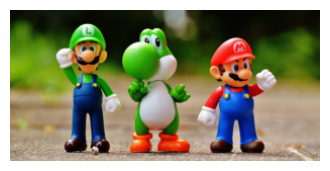

In [5]:
show_img(img2) # resized

In [6]:
def rgb2grey_py(x):
    c,h,w = x.shape # channel height weight
    n = h*w # how many pixels are there?
    x = x.flatten() # vectorize
    res = torch.empty(n, dtype=x.dtype, device=x.device) # creating an empty PyTorch tensor with a specified size (n), data type (dtype) & device
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n] # through every pixel. Apply book's formula
    return res.view(h,w) # reshape

In [7]:
%%time
img_g = rgb2grey_py(img2)

Wall time: 3.55 s


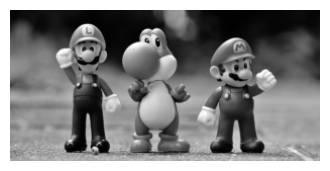

In [8]:
show_img(img_g, cmap='gray')

### Contrast enhancement

##### Why??

Contrast enhancement improves image visibility by emphasizing differences in intensity. Used for a better human visual perception or machine vision identification. This process involves redistributing pixel intensities, resulting in a more vibrant representation. Benefits include improved feature visibility, heightened image quality, and increased effectiveness of algorithms. The technique is widely applicable in various image processing tasks, contributing to enhanced visual analysis and interpretation.

In [9]:
def darken_image(image, factor):
    image_np = image.numpy() # tensor to numpy
    darkened_image_np = (image_np * factor).clip(0, 255).astype(np.uint8) # darkening image
    darkened_image_tensor = torch.from_numpy(darkened_image_np) # numpy to tensor

    return darkened_image_tensor

darkened_img_g = darken_image(img_g, 0.02)  # factor range: near 0 darker, near 1 no change.

###### Why darkening? 

to better verify the contrast enhancement process

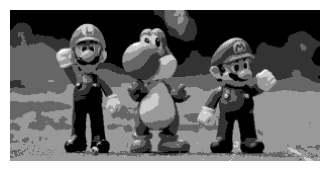

In [10]:
show_img(darkened_img_g, cmap='gray')

In [11]:
histogram, bins = np.histogram(img_g.flatten(), bins=256, range=[0, 256]) # histogram representing the distribution of pixel intensities.

In [12]:
cdf = histogram.cumsum() # Cumulative Distribution Function (CDF) from the histogram

In [13]:
cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min()) # normalizes the CDF to the range [0, 255].

In [14]:
enhanced_image = np.interp(img_g.flatten(), bins[:-1], cdf_normalized) # Use the normalized CDF as a mapping function to transform the original pixel intensities.
enhanced_image = enhanced_image.reshape(img_g.shape) # restores the shape of the image.

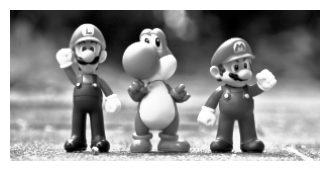

In [15]:
show_img(enhanced_image, cmap='gray')

### Delete Noise & Smoothing

##### Why??

images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF), etc. 
- LPF helps in removing noise, blurring images
- HPF filters help in finding edges in images.

#### Approach 1

In [16]:
# smoothing filter to reduce noise
kernel_size = 3
smoothed_image = cv2.blur(enhanced_image, (kernel_size, kernel_size))

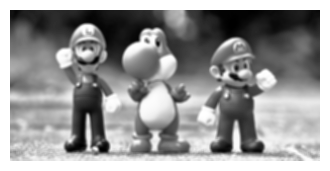

In [17]:
show_img(smoothed_image, cmap='gray')

#### Approach 2

convolve a kernel with an image. Kernel is a 5x5 averaging filter (Eg)

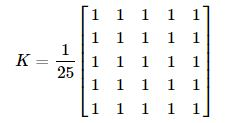

In [23]:
from IPython.display import Image, display
display(Image(filename='OpenCV- Smoothing-Images-Kernel.jpg'))

The convolution operation involves sliding the kernel over each pixel in the image and calculating the weighted average of the pixel values covered by the kernel. In this case, the kernel is an averaging kernel, so it computes the average of the pixel values in the local neighborhood.

- For each pixel in the image, the 5x5 kernel is centered above that pixel.
- The pixel values covered by the kernel are multiplied element-wise with the corresponding values in the kernel.
- The resulting products are summed, and the sum is divided by 25 to get the average.
- The central pixel in the output (dst) is then replaced with this average value.
- The process is repeated for all pixels in the image, resulting in a smoothed image.

In [24]:
kernel = np.ones((5,5),np.float32)/25
smoothed_img = cv2.filter2D(enhanced_image,-1,kernel)

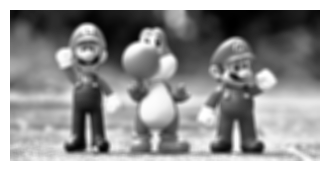

In [25]:
show_img(smoothed_img, cmap='gray')

Notebook: Approach 2 gives you more control over params and kernel definition. The choice between each approach depends on level of customization requiered for the smoothing operation.